In [1]:
import random 
random.seed(7)
import tensorflow as tf
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity
import matplotlib.pyplot as plt
from time import time
import tensorflow.keras.backend as k
import tensorflow.keras.callbacks as Callback


In [68]:
import random 
random.seed(7)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity
import matplotlib.pyplot as plt



In [2]:
# Data splitted in a ration 60: 20: 20:
train_dir = r'/kaggle/input/chest-xray-images-for-classification-pneumonia/train'
val_dir = r'/kaggle/input/chest-xray-images-for-classification-pneumonia/validation'
test_dir = r'/kaggle/input/chest-xray-images-for-classification-pneumonia/test'

In [ ]:
# Original directory (not needed, but kept for the future)
#train_dir='../input/chest-xray-pneumonia/chest_xray/chest_xray/train/'

In [3]:
import os
os.listdir(train_dir)

['NORMAL', 'PNEUMONIA']

In [7]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU not found, turn it on, on top right corner.")
else:
    print("Found GPU at: {}".format(device_name))

GPU not found, turn it on, on top right corner.


In [8]:
#train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)

In [173]:
def model_(SS, batch):
    
    #getting new metrics to calculate F1 at the end of the notebook
    Preci = tf.keras.metrics.Precision() 
    Recal = tf.keras.metrics.Recall() 
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range = 5, 
                                       horizontal_flip = True)
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        #verbose = 0,
        target_size = (150, 150),
        batch_size = batch,
        class_mode = 'binary')
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        #verbose = 0,
        target_size = (150, 150),
        batch_size = batch,
        class_mode='binary')
    
    try:
        with tf.device('/gpu:0'):
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(512, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', SensitivityAtSpecificity(SS), Preci, Recal])
    except:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(512, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', SensitivityAtSpecificity(SS), Preci, Recal])

    return model, train_generator, val_generator

In [174]:
SS = [ 9] # we divide them by 10 after to get: 0.5, 0.7, 0.9
batches = [32]
models = {}
train_generators = {}
val_generators = {}
for ss in SS:
    for batch in batches:
        model_ss_batch = 'models_{}_{}'.format(ss, batch)  # creating the keys
        models[model_ss_batch] = model_(ss//10, batch) # appending the model to the key
        
        train_generator_ss_batch = 'train_generators_{}_{}'.format(ss, batch)  # creating the keys
        train_generators[train_generator_ss_batch] = model_(ss//10, batch) # appending the generator to the key
        
        val_generator_ss_batch = 'val_generators_{}_{}'.format(ss, batch)  # creating the keys
        val_generators[val_generator_ss_batch] = model_(ss//10, batch) # appending the model to the key
        

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [175]:
print(models.keys()) #prints keys
print(train_generators.keys()) #prints keys
print(val_generators.keys()) #prints keys


dict_keys(['models_9_32'])
dict_keys(['train_generators_9_32'])
dict_keys(['val_generators_9_32'])


This loop will create 9 models combining: SensitivityatSpecificity vale

Here, we fit all the models created. we created a dictionary where 
we store each model for future usage and visualization

In [176]:
Final_models = {}
for i in range(len(models)):
    Final_model_i = 'models_{}'.format(i)  # creating the keys
    Final_models[Final_model_i] = models[list(models.keys())[i]][0].fit_generator(
        train_generators[list(train_generators.keys())[i]][1],
        steps_per_epoch = None, # = 3513 / 8
        verbose = 2,
        epochs = 10,
        validation_data = val_generators[list(val_generators.keys())[i]][1],
        validation_steps = None # = 1172 / 8
)
    
    

Train for 110 steps, validate for 110 steps
Epoch 1/10
110/110 - 165s - loss: 0.5143 - acc: 0.7552 - sensitivity_at_specificity_296: 1.0000 - precision_28: 0.7562 - recall_28: 0.9809 - val_loss: 0.3878 - val_acc: 0.8130 - val_sensitivity_at_specificity_296: 1.0000 - val_precision_28: 0.8020 - val_recall_28: 0.9875
Epoch 2/10
110/110 - 163s - loss: 0.3502 - acc: 0.8571 - sensitivity_at_specificity_296: 1.0000 - precision_28: 0.8682 - recall_28: 0.9481 - val_loss: 0.2735 - val_acc: 0.9038 - val_sensitivity_at_specificity_296: 1.0000 - val_precision_28: 0.9291 - val_recall_28: 0.9399
Epoch 3/10
110/110 - 163s - loss: 0.2816 - acc: 0.8844 - sensitivity_at_specificity_296: 1.0000 - precision_28: 0.9062 - recall_28: 0.9388 - val_loss: 0.2293 - val_acc: 0.9143 - val_sensitivity_at_specificity_296: 1.0000 - val_precision_28: 0.9387 - val_recall_28: 0.9442
Epoch 4/10
110/110 - 163s - loss: 0.2472 - acc: 0.9009 - sensitivity_at_specificity_296: 1.0000 - precision_28: 0.9207 - recall_28: 0.9458 -

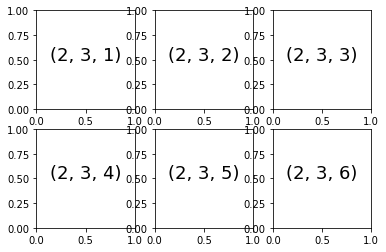

In [179]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')

In [188]:
# Ok, what do we have here??
print(Final_models.keys())
Final_models['models_0'].history.keys()

dict_keys(['models_0'])


dict_keys(['loss', 'acc', 'sensitivity_at_specificity_296', 'precision_28', 'recall_28', 'val_loss', 'val_acc', 'val_sensitivity_at_specificity_296', 'val_precision_28', 'val_recall_28'])

In [207]:
Final_models[list(Final_models.keys())[i]]

IndexError: list index out of range

In [206]:
Final_models['models_0']

Populating the interactive namespace from numpy and matplotlib
0


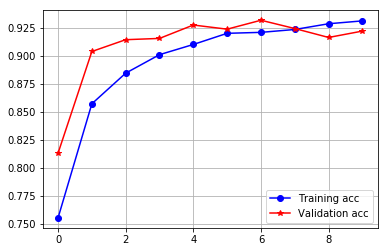

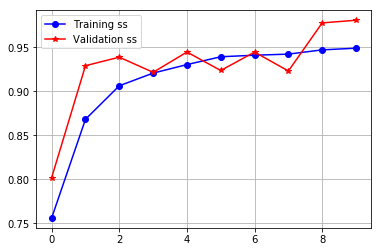

In [215]:
%pylab inline
for i in range(len(Final_models)):
    print(i)
    acc = Final_models[list(Final_models.keys())[i]].history['acc']
    val_acc = Final_models[list(Final_models.keys())[i]].history['val_acc']
    
    senspe = Final_models[list(Final_models.keys())[i]].history['precision_28']
    val_senspe = Final_models[list(Final_models.keys())[i]].history['val_precision_28']
    #loss_1 = history_1.history['loss']
    #val_loss_1 = history_1.history['val_loss']
      
    epochs = range(len(acc))

plot(epochs, acc, 'bo-', label = 'Training acc')
plot(epochs, val_acc, 'r*-', label = 'Validation acc')
legend()
grid()
show()

plot(epochs, senspe, 'bo-', label = 'Precision_training ss')
plot(epochs, val_senspe, 'r*-', label = 'Precision validation')
legend()
grid()
show()

In [193]:
epochs

range(0, 10)

In [ ]:
train_generator = train_datagen.flow_from_directory(

    train_dir,
    
    target_size=(150, 150),
    
    batch_size=16,
    
    class_mode='binary',
    
    subset='training')
    
     
dev_generator = train_datagen.flow_from_directory(

            train_dir,
    
            target_size=(150, 150),
    
            batch_size=16,
    
            class_mode='binary',
    
            subset='validation')
    

In [ ]:
#here we 70% Training and 30% test which is good!

In [ ]:
# WE DO NOT NEED THIS CRAP
#i = 0 
#for data_batch, labels_batch in train_generator:
#    print('data batch shape:',data_batch.shape)
#    print('labels batch shape:',labels_batch.shape)
#    i = i + 1
#    if i> 5:
#        break
    
    

In [ ]:
#labels_batch

**Visualize training images**

Visualising the training images by extracting a batch of images from the training generator—which is 16 images in this example—then plot five of them with matplotlib.

In [ ]:
#sample_training_images, _ = next(train_generator) # NOT NEEDED UNLESS WE USE THE TPU!

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
#def plotImages(images_arr):
##    fig, axes = plt.subplots(1, 5, figsize=(20,20))
#    axes = axes.flatten()
#    for img, ax in zip( images_arr, axes):
#        ax.imshow(img)
#        ax.axis('off')
#    plt.tight_layout()
#    plt.show()

In [ ]:
#plotImages(sample_training_images[:5])

## Creating the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a relu activation function. The model outputs class probabilities based on binary classification by the sigmoid activation function.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation ='relu',input_shape = (150,150,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32,(3,3), activation ='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32,(3,3), activation ='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32,(3,3), activation ='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation= 'relu'))
model.add(layers.Dense(1,activation='sigmoid'))

Compiling the model

choosing the RMSprop optimizer and binary cross entropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [ ]:
import tensorflow as tf
from sklearn.metrics import  f1_score
from tensorflow.python.keras import optimizers
Preci = tf.keras.metrics.Precision() 
Recal = tf.keras.metrics.Recall()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Preci, Recal, 'acc'])

In [ ]:
import time
start = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 10,
    verbose = 1,
    epochs = 10, # change epochs: originally 10, 100, 200, 300
    validation_data = dev_generator,
    validation_steps = 10,
    workers = 0, # 0 and 1
    use_multiprocessing = True)
end = time.time()

print(end-start) #62.2 (2 workers),


print(history.history.keys()):

In [ ]:
print(history.history.keys())

In [ ]:
accu = history.history['acc'] #training accuracy
val_accu = history.history['val_acc'] #validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accu))

# Precision
Precision = history.history['precision_1'] #training accuracy
val_Precision = history.history['val_precision_1'] #validation accuracy
Precision_np = np.asarray(Precision, dtype=np.float32)

# Recall
Recall = history.history['recall_1'] #training accuracy
val_Recall = history.history['val_recall_1'] #validation accuracy
Recall_np = np.asarray(Precision, dtype=np.float32)

In [ ]:
# A WELL Tailored F1 score metric
F1 = 2*(np.divide(np.multiply(Precision_np, Recall_np),np.add(Precision_np, Recall_np)))

In [ ]:
plot(epochs, accu, 'bo-', label = 'Training acc')
plot(epochs, val_accu, 'r*-', label = 'Validation acc')
plot(epochs, F1, 'black', label = 'F1')
legend()
grid()
show()

See the black liine is F1 score!

Creating a new network with Dropouts

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
model_new = models.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(150, 150 ,3)), #stride =2 default 1 
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

In [ ]:
start = time()
history = model_new.fit_generator(
    train_generator,
    steps_per_epoch = 10,
    verbose = 0,
    epochs = 100, # change epochs: originally 10, 100, 200, 300
    validation_data = dev_generator,
    validation_steps = 10)
end = time()
#save model:
model.save('case2_v2.0.h5') # every time 0.1, 0.2....
print('time elapsed:', end - start)

In [ ]:
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accu))

In [ ]:
plot(epochs, accu, 'bo-', label = 'Training acc')
plot(epochs, val_accu, 'r*-', label = 'Validation acc')
legend()
grid()
show()

In [ ]:
plot(epochs, loss, 'bo-', label = 'Training loss')
plot(epochs, val_loss, 'r*-', label = 'Validation loss')
legend()
grid()
show()